# Principal Component Analysis (PCA)

Using PCA for images.
Image used in the notebook is a painting [Troiana Iris (detail)](https://www.wikiart.org/en/albrecht-durer/troiana-iris-detail) by Albrecht Durer.

In [23]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pca

# Fancy PCA

Fancy PCA augmentation was introduced in [AlexNet](https://papers.nips.cc/paper_files/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) paper. The description is as follows:

```
The second form of data augmentation consists of altering the intensities of the RGB channels in training images. Specifically, we perform PCA on the set of RGB pixel values throughout the ImageNet training set. To each training image, we add multiples of the found principal components,with magnitudes proportional to the corresponding eigenvalues times a random variable drawn from a Gaussian with mean zero and standard deviation 0.1. Therefore to each RGB image pixel
```
    $I_{xy} = [I_{xy}^R , I_{xy}^G , I_{xy}^B ]^T$ we add the following quantity: $[p1, p2, p3][\alpha1 \lambda1, \alpha2 \lambda2, \alpha3 \lambda3]^T$
    
```
where pi and λi are ith eigenvector and eigenvalue of the 3 × 3 covariance matrix of RGB pixel values, respectively, and αi is the aforementioned random variable. Each αi is drawn only once for all the pixels of a particular training image until that image is used for training again, at which point it is re-drawn. This scheme approximately captures an important property of natural images, namely, that object identity is invariant to changes in the intensity and color of the illumination. This scheme reduces the top-1 error rate by over 1%.
```

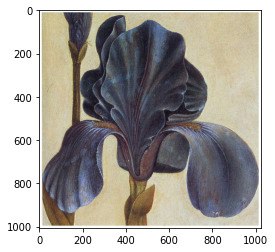

In [85]:
img = cv2.imread('troiana-iris-detail.jpg')
img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB))/255
img_shape = img.shape

plt.figure()
plt.imshow(img)

In [86]:
flattened_img = img.reshape(-1, 3)

# Perform PCA
img_pca = pca.PCA()
preprocessed_img = img_pca.preprocess(flattened_img) # Zero-mean the data
print(preprocessed_img.max(), preprocessed_img.min())
img_pca.forward(preprocessed_img)
pca_params = img_pca.get_params()
pca_params

0.5133572949553324 -0.5363660028176529
Computing eigen vectors


{'mean': array([0.536366  , 0.51569525, 0.48664271]),
 'std': None,
 'eig_val': array([0.1937288 , 0.00544296, 0.00049258]),
 'eig_vec': array([[-0.6240655 , -0.52911775, -0.57495796],
        [-0.61672121, -0.11827919,  0.77824481],
        [-0.4797887 ,  0.8402645 , -0.25250418]])}

Since, we are doing PCA in the colourspace we should be able to attribute each principal component to a colour.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


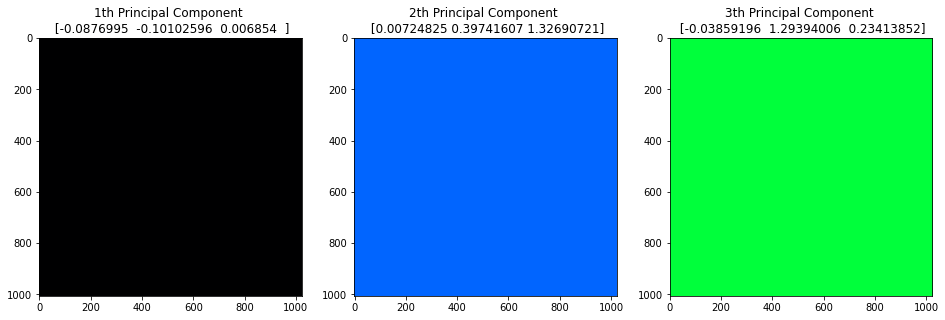

In [87]:
# Visualize each principal component
num_components = pca_params['eig_val'].shape[0]

fig, ax = plt.subplots(1, num_components, figsize=(16, 8))

for i in range(num_components):
    principal_component = (pca_params['eig_vec'][:, i] + img_pca.get_params()['mean'])
    img_temp = np.full(img.shape, principal_component)
    ax[i].imshow(img_temp)
    ax[i].title.set_text(f'{i+1}th Principal Component \n {principal_component}')
plt.show()

The principal components have negative values and values greater than $1$ due to which the matplotlib is clipping the values to be between $[0, 1]$. We can do the preprocessing in a slightly different way to work-around with this problem. Instead of subtracting it with mean, we can make sure the colour values are between $[-1, 1]$ by subtacting and dividing by $128$. This way all the principal components can be projected back to the colour space for interpretation.

NOTE: The negative values of the principal components which makes it difficult to interpret in certain applications is one of the limitations of PCA. Look for Non-Negative Matrix Factorization to overcome this limitation.

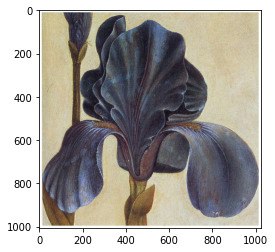

In [89]:
img = cv2.imread('troiana-iris-detail.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_shape = img.shape

plt.figure()
plt.imshow(img)

In [90]:
img = (img.astype(np.float32) - 128)/128

flattened_img = img.reshape(-1, 3)

# Perform PCA
img_pca = pca.PCA()
img_pca.forward(flattened_img)
pca_params = img_pca.get_params()
pca_params

Computing eigen vectors


{'mean': None,
 'std': None,
 'eig_val': array([0.768873  , 0.02160207, 0.00195494]),
 'eig_vec': array([[-0.6240655 , -0.52911775, -0.57495796],
        [-0.61672121, -0.11827919,  0.77824481],
        [-0.4797887 ,  0.8402645 , -0.25250418]])}

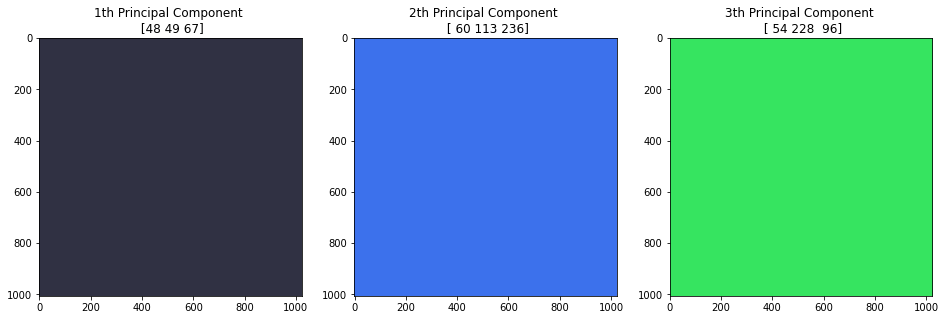

In [91]:
# Visualize each principal component
num_components = pca_params['eig_val'].shape[0]

fig, ax = plt.subplots(1, num_components, figsize=(16, 8))

for i in range(num_components):
    principal_component = np.rint((pca_params['eig_vec'][:, i]*128 + 128)).astype(np.uint8)
    img_temp = np.full(img.shape, principal_component)
    ax[i].imshow(img_temp)
    ax[i].title.set_text(f'{i+1}th Principal Component \n {principal_component}')
plt.show()

Note that with the change in the way of pre-processing the data, the eigenvectors have almost remain the same whereas the eigenvalues have changed significantly. Moreover, each principal component is now slightly more interpretable (no negative values and each component is within $[0, 255]$).

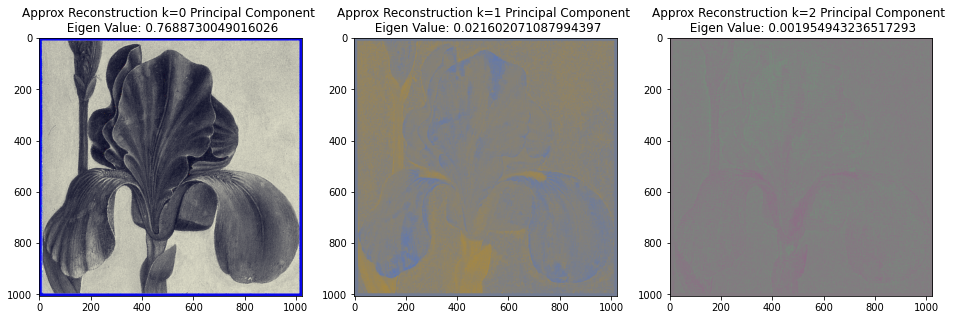

In [92]:
# Visualize the approximate reconstruction by projecting onto each principal component

def visualize_approx_recon(img, pca_params, img_shape):
    num_components = pca_params['eig_val'].shape[0]
    
    fig, ax = plt.subplots(1, num_components, figsize=(16, 8))
    
    for i in range(num_components):
        eig_vector = pca_params['eig_vec'][:, i]
        projection = np.dot(img, eig_vector)
        eigen_approx = (((np.expand_dims(projection, axis=1) * eig_vector *128 + 128))).reshape(img_shape).astype(np.uint8)
        ax[i].imshow(eigen_approx)
        ax[i].title.set_text(f'Approx Reconstruction k={i} Principal Component \n Eigen Value: {pca_params["eig_val"][i]}')
    plt.show()
    
visualize_approx_recon(flattened_img, pca_params, img_shape)

Since the content of the image (the flower) is visible in the first principal reconstruction, hence we can say that the maximum variance is retained here. Fancy PCA is trying to find the colour/direction along which if we project, the maximum variance (i.e. all the objects) in the image will be retained. Therefore, if we take any vector perpendicular to this principal direction, the variance should be very less or the objects in the image should be least distinguishable. Can this be used for segmentation? Let's use the projections onto the first principal component and try to see if we can find clusters.

(1030144,)


<AxesSubplot: ylabel='Density'>

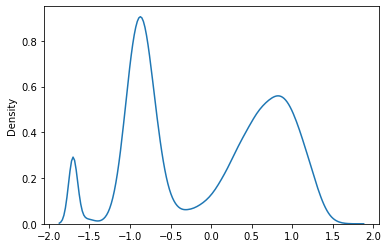

In [93]:
projections = np.dot(flattened_img, pca_params['eig_vec'][:, 0])
print(projections.shape)
sns.kdeplot(data=projections)

The 3 peaks correspond to: The flower, the background and the thin white border. Here, I will use a crude thresholding to identify clusters. However, we can use sophisticated algorithms like Mean Shift etc. to identify clusters.

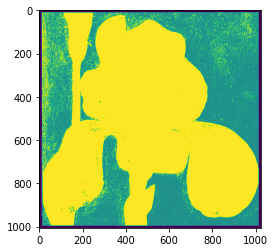

In [94]:
segmented = np.zeros_like(projections)
segmented[projections > -1.5] = 0.5
segmented[projections >= -0.7] = 1
plt.imshow(segmented.reshape(img_shape[:2]))
plt.show()

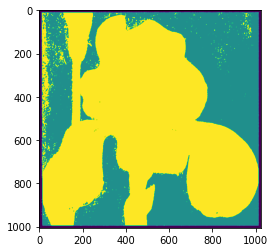

In [95]:
# Median Blurring to improve the mask
segmented = (segmented.reshape(img_shape[:2])*255).astype(np.uint8)
segmented = cv2.medianBlur(segmented, 5)
plt.imshow(segmented.reshape(img_shape[:2]))
plt.show()

To make the effect of Fancy PCA augmentation visible, multiply the random vector by 500, similar to [here](https://pixelatedbrian.github.io/2018-04-29-fancy_pca/).

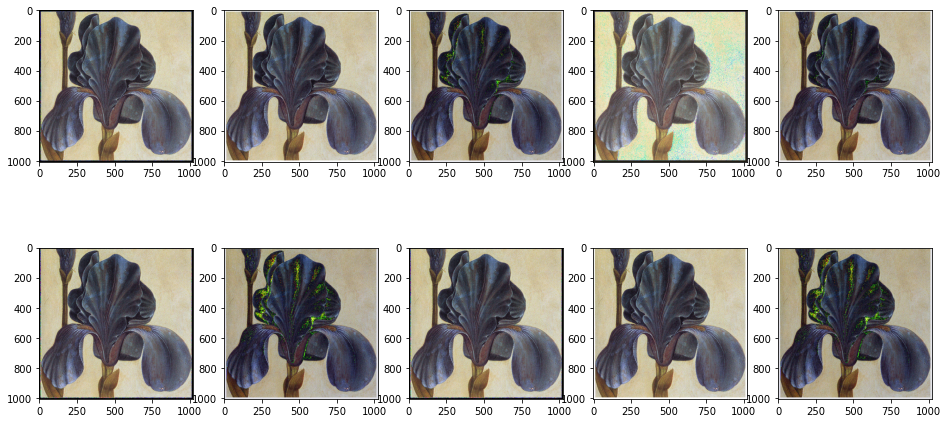

In [96]:
# Fancy PCA augmentation
def fancy_pca(img, pca_params, alpha_std=0.1, multiplier=1000):
    alpha = multiplier*np.random.normal(loc=0.0, scale=alpha_std, size=pca_params['eig_val'].shape)
    return img + np.dot(pca_params['eig_vec'], (pca_params['eig_val']*alpha).T)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i in range(10):
    ori_img = (img*128 + 128)
    aug_img = fancy_pca(ori_img, pca_params, multiplier=500)
    aug_img = aug_img.astype(np.uint8)
    aug_img = aug_img.reshape(img_shape)
    ax[i//5, i%5].imshow(aug_img)
plt.show()